In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
CFG = {
    'sigmoid': True,
    'bias': True,
    'init': True,
    'lr': 0.005,
    'num_epochs': 50,
}

## EDA and Data Preprocessing

In [3]:

data = pd.read_csv("anime_with_synopsis.csv")
# Delete unfit data
data["movie_ID"] = data.Name.astype('category').cat.rename_categories([int(data) for data in range(1,data.Name.nunique()+1)])
print(sum(data["Score"] == "Unknown"))
data = data[data["Score"] != "Unknown"]

print(sum(data["movie_ID"].isna()))
print(sum(data["MAL_ID"].isna()))

# Turn user ID to int
data["MAL_ID"] = [int(string) for string in data["MAL_ID"]]
data["Score"] = [float(string) for string in data["Score"]]
data

5123
0
0


,MAL_ID,Name,Score,Genres,sypnopsis,movie_ID
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",2392
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",2394
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",14571
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,15318
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,1582
...,...,...,...,...,...,...
16157,47398,Kimetsu Gakuen: Valentine-hen,6.59,Comedy,Valentine's Day special for Kimetsu no Yaiba ....,7012
16158,47402,Heikousen,7.52,"Music, Romance","usic video for Eve and suis' song Heikousen , ...",5042
16165,47614,Nu Wushen de Canzhuo Spring Festival Special,6.83,"Slice of Life, Comedy",No synopsis information has been added to this...,10147
16166,47616,Yakusoku no Neverland 2nd Season: Michishirube,4.81,"Mystery, Psychological, Supernatural, Thriller...",cap of the first season of Yakusoku no Neverla...,15530


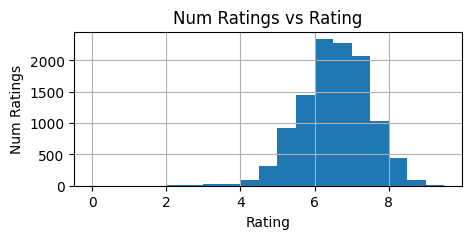

In [5]:
plt.figure(figsize=(5,2))
bins = np.arange(0,10,0.5)
plt.hist(data["Score"], bins=bins)
#plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.title('Num Ratings vs Rating')
plt.xlabel('Rating')
plt.ylabel('Num Ratings')
plt.grid();

In [6]:
# Use LabelEncoder to convert users and movies into categorical
# This step remaps each column integer range to [0, len(df.column.unique())-1]
# Remapping is useful to reduce memory size of nn.embeddings
d = defaultdict(LabelEncoder)
cols_cat = ['MAL_ID', 'movie_ID']
for c in cols_cat:
    d[c].fit(data[c].unique())
    data[c] = d[c].transform(data[c])
    print(f'# unique {c}: {len(d[c].classes_)}')

min_num_ratings = data.groupby(['MAL_ID'])['MAL_ID'].transform(len).min()
print(f'Min # of ratings per user: {min_num_ratings}')
print(f'Min/Max rating: {data.Score.min()}/{data.Score.max()}')
print(f'df.shape: {data.shape}')
data.head(10)

# unique MAL_ID: 11091
# unique movie_ID: 11090
Min # of ratings per user: 1
Min/Max rating: 1.85/9.19
df.shape: (11091, 6)


,MAL_ID,Name,Score,Genres,sypnopsis,movie_ID
0,0,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",1776
1,1,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",1778
2,2,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",10065
3,3,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,10547
4,4,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,1212
5,5,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",Sena is like any other shy kid starting high s...,2626
6,6,Hachimitsu to Clover,8.06,"Comedy, Drama, Josei, Romance, Slice of Life","Yuuta Takemoto, a sophomore at an arts college...",3498
7,7,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",Kyosuke Kano has lived under the shadow of his...,4122
8,8,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",Takumi Fujiwara finally joins Ryousuke and Kei...,4314
9,9,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,...","Dr. Kenzou Tenma, an elite neurosurgeon recent...",6607


In [7]:
class AnimeDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df[['MAL_ID', 'movie_ID', 'Score']]
        self.x_user_anime = list(zip(df.MAL_ID.values, df.movie_ID.values))
        self.y_rating = self.df.Score.values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.x_user_anime[idx], self.y_rating[idx]

In [8]:
BS = 8192
ds_train = AnimeDataset(data)
dl_train = DataLoader(ds_train, BS, shuffle=True)

In [31]:
xb, yb = next(iter(dl_train))
print(xb)
print(yb)
print(xb[0].size())

[tensor([ 2399, 10995,   638,  ...,  5103,  5301,  9866]), tensor([ 642, 2357, 1733,  ..., 7229, 7942,  820])]
tensor([5.6000, 8.0600, 6.5200,  ..., 5.2700, 4.1800, 6.4700],
       dtype=torch.float64)
torch.Size([8192])


In [10]:
def sigmoid_range(x, low, high):
    """ Sigmoid function with range (low, high) """
    return torch.sigmoid(x) * (high-low) + low

class MFAdvanced(nn.Module):
    """ Matrix factorization + user & item bias, weight init., sigmoid_range """
    def __init__(self, num_users, num_items, emb_dim, init, bias, sigmoid):
        super().__init__()
        self.bias = bias
        self.sigmoid = sigmoid
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        if bias:
            self.user_bias = nn.Parameter(torch.zeros(num_users))
            self.item_bias = nn.Parameter(torch.zeros(num_items))
            self.offset = nn.Parameter(torch.zeros(1))
        if init:
            self.user_emb.weight.data.uniform_(0., 0.05)
            self.item_emb.weight.data.uniform_(0., 0.05)
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        element_product = (user_emb*item_emb).sum(1)
        if self.bias:
            user_b = self.user_bias[user]
            item_b = self.item_bias[item]
            element_product += user_b + item_b + self.offset
        if self.sigmoid:
            return sigmoid_range(element_product, 0, 5.5)
        return element_product

In [11]:
def round_to_0p5(list_nums):
    """ Helper func to round nums to nearest 0.5, eg 1.45 -> 1.5 """
    return np.round(np.array(list_nums)*2)/2

In [12]:
n_users = len(data.MAL_ID.unique())
n_items = len(data.movie_ID.unique())
mdl = MFAdvanced(n_users, n_items, emb_dim=32,
                 init=CFG['init'],
                 bias=CFG['bias'],
                 sigmoid=CFG['sigmoid'],
)
mdl.to(device)
print(dict(mdl.named_parameters()).keys())

dict_keys(['user_bias', 'item_bias', 'offset', 'user_emb.weight', 'item_emb.weight'])


In [14]:
opt = optim.AdamW(mdl.parameters(), lr=CFG['lr'])
loss_fn = nn.MSELoss()
epoch_train_losses = []

for i in range(CFG['num_epochs']):
    train_losses, val_losses = [], []
    mdl.train()
    for xb,yb in dl_train:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    # Start logging
    epoch_train_loss = np.mean(train_losses)
    epoch_train_losses.append(epoch_train_loss)
    s = (f'Epoch: {i}, Train Loss: {epoch_train_loss:0.1f}')
    print(s)

Epoch: 0, Train Loss: 14.6
Epoch: 1, Train Loss: 14.2
Epoch: 2, Train Loss: 13.7
Epoch: 3, Train Loss: 13.3
Epoch: 4, Train Loss: 12.8
Epoch: 5, Train Loss: 12.4
Epoch: 6, Train Loss: 11.9
Epoch: 7, Train Loss: 11.5
Epoch: 8, Train Loss: 10.8
Epoch: 9, Train Loss: 10.4
Epoch: 10, Train Loss: 9.9
Epoch: 11, Train Loss: 9.4
Epoch: 12, Train Loss: 8.9
Epoch: 13, Train Loss: 8.4
Epoch: 14, Train Loss: 7.9
Epoch: 15, Train Loss: 7.4
Epoch: 16, Train Loss: 7.0
Epoch: 17, Train Loss: 6.5
Epoch: 18, Train Loss: 6.2
Epoch: 19, Train Loss: 5.8
Epoch: 20, Train Loss: 5.4
Epoch: 21, Train Loss: 5.1
Epoch: 22, Train Loss: 4.8
Epoch: 23, Train Loss: 4.5
Epoch: 24, Train Loss: 4.3
Epoch: 25, Train Loss: 4.1
Epoch: 26, Train Loss: 3.8
Epoch: 27, Train Loss: 3.7
Epoch: 28, Train Loss: 3.5
Epoch: 29, Train Loss: 3.4
Epoch: 30, Train Loss: 3.3
Epoch: 31, Train Loss: 3.2
Epoch: 32, Train Loss: 3.0
Epoch: 33, Train Loss: 3.0
Epoch: 34, Train Loss: 2.9
Epoch: 35, Train Loss: 2.8
Epoch: 36, Train Loss: 2.7
E

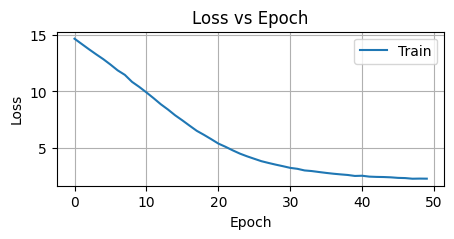

In [15]:
plt.figure(figsize=(5,2))
plt.plot(epoch_train_losses, label='Train')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend();

In [98]:
# Get the top k suggested items for a given user "user"
def recommendations(user, top_k = 10):
    scores = []
    unique_items = data["movie_ID"].unique()
    for anime in unique_items:
        score = mdl(torch.Tensor([user]).to(torch.int64), 
                    torch.Tensor([anime]).to(torch.int64))
        scores.append((anime, score))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    top_animes = [i[0] for i in scores[:top_k]]
    
    recommended_animes = [data[["Name"]].loc[data["MAL_ID"] == rec_anime] for rec_anime in top_animes]
    recommended_animes = [rec_anime.values[0] for rec_anime in recommended_animes]
    return recommended_animes

## A user is randomly selected and k recommendations are generated for it.
Note that usually a specific user will be selected, not a random one; this is just to make it easy to test the model a bit.
If you want to test for a specific user, just input a user ID instead of the randomly generated value

In [199]:
import random
random.seed(13)

In [198]:
random_user = random.randrange(len(data["MAL_ID"]))
recommended_animes = recommendations(random_user, 10)
print("User ID: " + str(random_user) + "\n\nRecommended Animes: ")
recommended_animes

User ID: 4805

Recommended Animes: 


[array(['Magic Kaito'], dtype=object),
 array(["Yoshinaga-san'chi no Gargoyle Specials"], dtype=object),
 array(['Robo to Shoujo (Kari)'], dtype=object),
 array(['Zekkyou Gakkyuu'], dtype=object),
 array(['Densetsu Kyojin Ideon: Hatsudou-hen'], dtype=object),
 array(['009-1'], dtype=object),
 array(['Cluster Edge Specials'], dtype=object),
 array(['Bouken Dankichi: Hyouryuu no Maki'], dtype=object),
 array(['Code Geass: Hangyaku no Lelouch II - Handou'], dtype=object),
 array(['Kamisama no Memochou'], dtype=object)]